In [3]:
# @title
#from google.cloud import storage
#from google.colab import auth
import pandas as pd
from IPython.display import Image
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset
from torchvision import transforms, utils, models
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18, ResNet18_Weights, efficientnet_b0, EfficientNet_B0_Weights, resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import os
import time 
import lmdb
import pandas as pd
import os
import numpy as np
import cv2 
import pickle



In [5]:
# Load CSV from local path (Windows)

csv_path = "/mnt/d/Stanford_AIMI_CheXpert_Chest_X-rays/chexpertchestxrays-u20210408/train_visualCheXbert.csv"
#csv_path = "/mnt/c/Users/Jackb/Documents/Stanford_AIMI_CheXpert_Chest_X-rays/chexpertchestxrays-u20210408/train_visualCheXbert.csv"

print("Using csv_path:", csv_path)
try:
    df = pd.read_csv(csv_path)
    display(df.head())
    print(df.dtypes)
except FileNotFoundError:
    print(f"File not found: {csv_path}")

Using csv_path: /mnt/d/Stanford_AIMI_CheXpert_Chest_X-rays/chexpertchestxrays-u20210408/train_visualCheXbert.csv


,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Path                           object
Sex                            object
Age                             int64
Frontal/Lateral                object
AP/PA                          object
Enlarged Cardiomediastinum    float64
Cardiomegaly                  float64
Lung Opacity                  float64
Lung Lesion                   float64
Edema                         float64
Consolidation                 float64
Pneumonia                     float64
Atelectasis                   float64
Pneumothorax                  float64
Pleural Effusion              float64
Pleural Other                 float64
Fracture                      float64
Support Devices               float64
No Finding                    float64
dtype: object


## Data Processing

In [7]:
# Diagnosis Columns
diagnosis_cols = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", "Edema",
    "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
    "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"
]
# print type
print(df.dtypes)

Path                           object
Sex                            object
Age                             int64
Frontal/Lateral                object
AP/PA                          object
Enlarged Cardiomediastinum    float64
Cardiomegaly                  float64
Lung Opacity                  float64
Lung Lesion                   float64
Edema                         float64
Consolidation                 float64
Pneumonia                     float64
Atelectasis                   float64
Pneumothorax                  float64
Pleural Effusion              float64
Pleural Other                 float64
Fracture                      float64
Support Devices               float64
No Finding                    float64
dtype: object


#### Data Overview and Visualization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223414 non-null  object 
 1   Sex                         223414 non-null  object 
 2   Age                         223414 non-null  int64  
 3   Frontal/Lateral             223414 non-null  object 
 4   AP/PA                       191027 non-null  object 
 5   Enlarged Cardiomediastinum  223414 non-null  float64
 6   Cardiomegaly                223414 non-null  float64
 7   Lung Opacity                223414 non-null  float64
 8   Lung Lesion                 223414 non-null  float64
 9   Edema                       223414 non-null  float64
 10  Consolidation               223414 non-null  float64
 11  Pneumonia                   223414 non-null  float64
 12  Atelectasis                 223414 non-null  float64
 13  Pneumothorax  

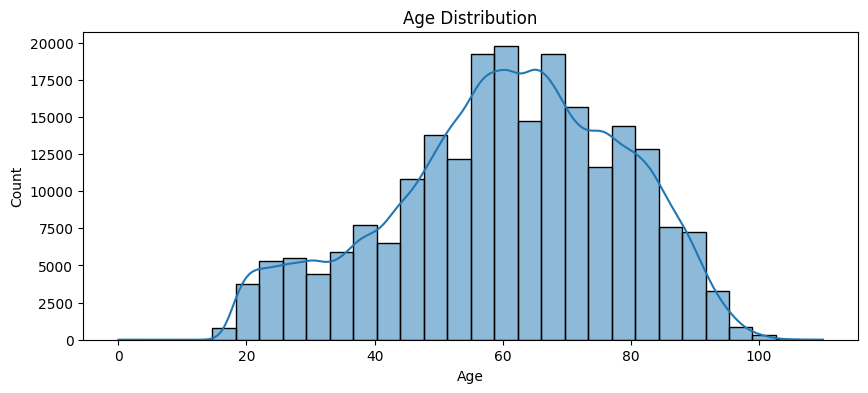

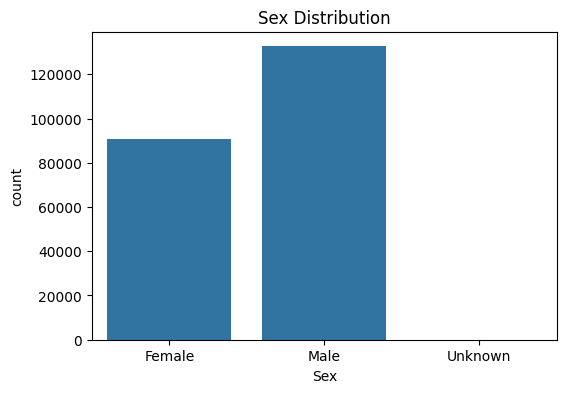

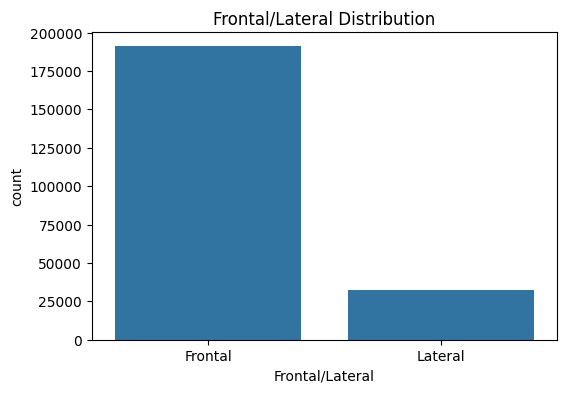

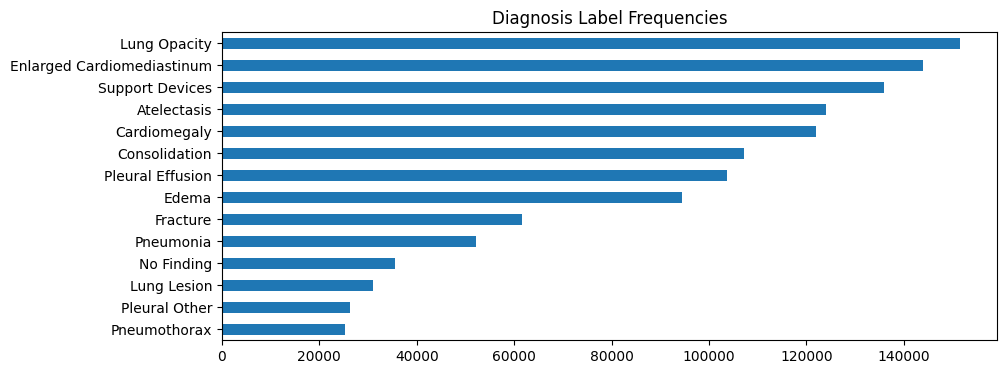

In [8]:
# Intitial Data Visualization
print(df.info())
print(df.describe(include='all'))

# Age Distribution
plt.figure(figsize=(10,4))
sns.histplot(df["Age"].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

#Sex Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Sex", data=df)
plt.title("Sex Distribution")
plt.show()

#Frontal/Lateral Xray Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Frontal/Lateral", data=df)
plt.title("Frontal/Lateral Distribution")
plt.show()

# Diagnosis Frequency
plt.figure(figsize=(10,4))
df[diagnosis_cols].sum().sort_values().plot(kind='barh')
plt.title("Diagnosis Label Frequencies")
plt.show()

#### Correlations

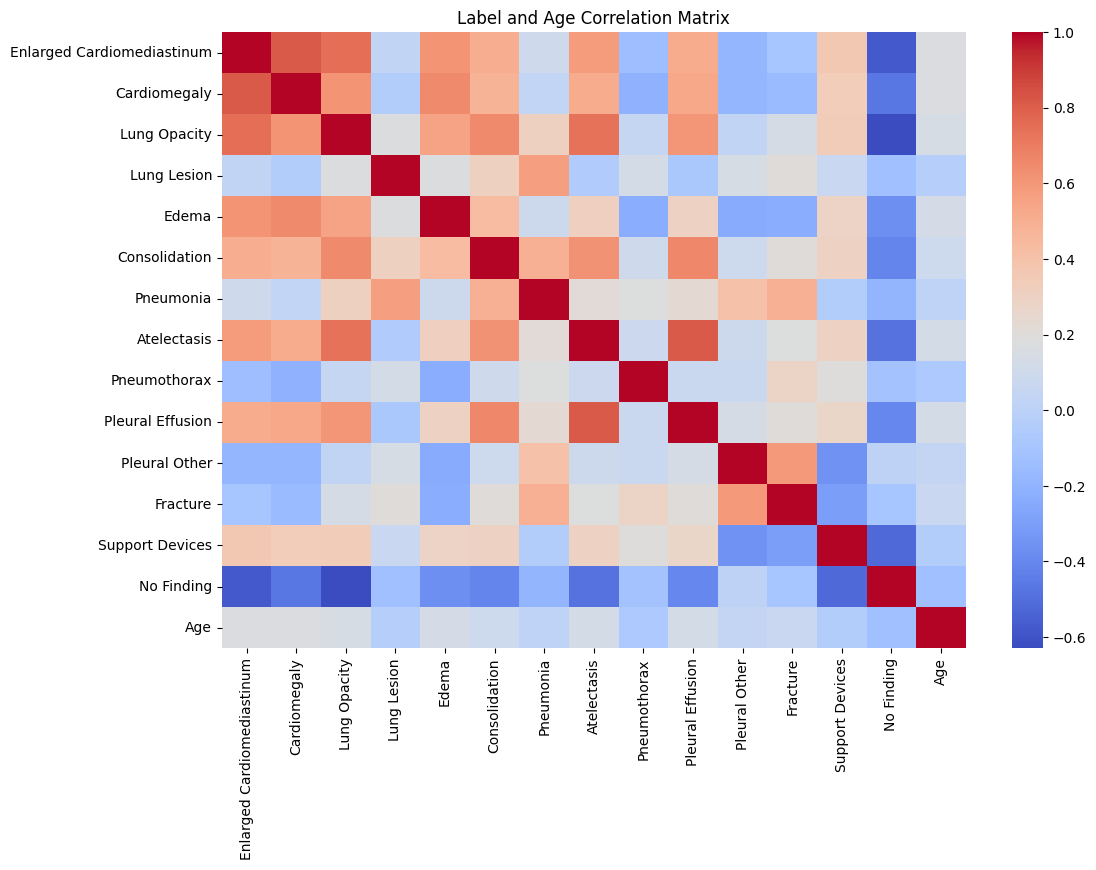

In [9]:
# Correlations
corr_matrix = df[diagnosis_cols + ["Age"]].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Label and Age Correlation Matrix")
plt.show()

#### Attribute Engineering

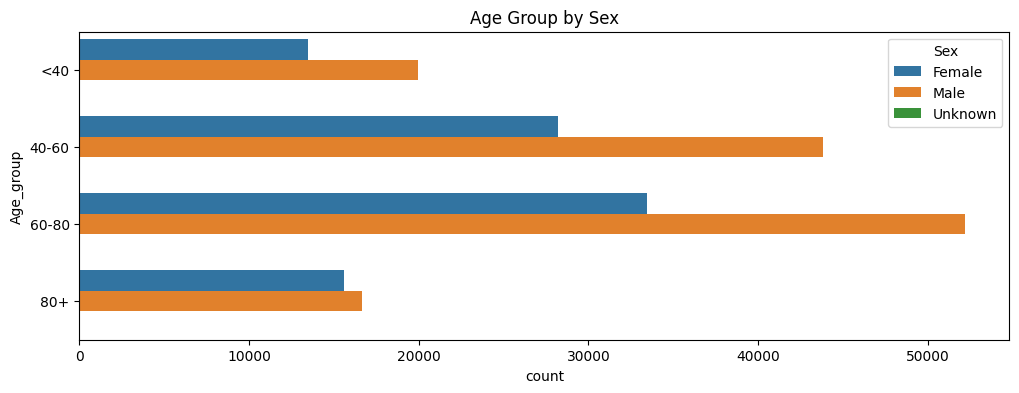

In [10]:
# Attribute Engineering
df['Age_group'] = pd.cut(df['Age'], bins=[0, 40, 60, 80, 120], labels=['<40','40-60','60-80','80+'])
df['View_Combo'] = df['Frontal/Lateral'].astype(str) + "_" + df['AP/PA'].fillna("Unknown").astype(str)

# Composite bar plot example
plt.figure(figsize=(12,4))
sns.countplot(y="Age_group", hue="Sex", data=df)
plt.title("Age Group by Sex")
plt.show()

#### Data Cleaning

Missing values per column:
 Path                              0
Sex                               0
Age                               0
Frontal/Lateral                   0
AP/PA                         32387
Enlarged Cardiomediastinum        0
Cardiomegaly                      0
Lung Opacity                      0
Lung Lesion                       0
Edema                             0
Consolidation                     0
Pneumonia                         0
Atelectasis                       0
Pneumothorax                      0
Pleural Effusion                  0
Pleural Other                     0
Fracture                          0
Support Devices                   0
No Finding                        0
Age_group                         3
View_Combo                        0
dtype: int64


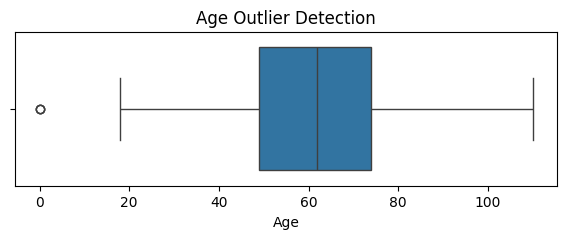

Preprocessing complete. Sample of processed dataframe:
                                                Path   Age  \
0  CheXpert-v1.0/train/patient00001/study1/view1_...  68.0   
1  CheXpert-v1.0/train/patient00002/study2/view1_...  87.0   
2  CheXpert-v1.0/train/patient00002/study1/view1_...  83.0   
3  CheXpert-v1.0/train/patient00002/study1/view2_...  83.0   
4  CheXpert-v1.0/train/patient00003/study1/view1_...  41.0   

   Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  Lung Lesion  Edema  \
0                           0             0             0            0      0   
1                           1             1             1            0      1   
2                           1             1             1            1      0   
3                           1             1             1            1      0   
4                           1             1             1            0      1   

   Consolidation  Pneumonia  Atelectasis  ...  AP/PA_PA  AP/PA_RL  \
0              0

In [11]:
# Missing Value Evaluation
print("Missing values per column:\n", df.isnull().sum())
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Sex'] = df['Sex'].fillna('Unknown')
df['Frontal/Lateral'] = df['Frontal/Lateral'].fillna('Unknown')
df['AP/PA'] = df['AP/PA'].fillna('Unknown')
df[diagnosis_cols] = df[diagnosis_cols].fillna(0).astype('int')


# Outlier handling for Age
plt.figure(figsize=(7,2))
sns.boxplot(x=df["Age"])
plt.title("Age Outlier Detection")
plt.show()
df = df[(df["Age"] >= 18) & (df["Age"] <= 100)]  # Cap age to plausible range

# Feature Scaling
scaler = StandardScaler()
df["Age_scaled"] = scaler.fit_transform(df[["Age"]])

# Encoding Categorical Features
df = pd.get_dummies(df, columns=["Sex", "Frontal/Lateral", "AP/PA", "Age_group", "View_Combo"], drop_first=True)


# Convert Booleans into float32
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
col_to_convert = bool_cols + ['Age']
df[col_to_convert] = df[col_to_convert].astype('float32')

# Dimensionality Reduction
from sklearn.decomposition import PCA
meta_features = df.drop(columns=["Path"] + diagnosis_cols)
pca = PCA(n_components=5)
meta_pca = pca.fit_transform(meta_features)

print("Preprocessing complete. Sample of processed dataframe:")
print(df.head())

## Model Training

In [12]:
# Pytorch Dataset
class XrayMultiModalDataset(Dataset):
    def __init__(self, dataframe, image_root_local, tabular_cols, label_cols, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_root = image_root_local
        self.tabular_cols = tabular_cols
        self.label_cols = label_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_root, self.df.loc[idx, 'Path'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tabular Features - ensure numeric and convert to tensor
        tabular_data = torch.tensor(self.df.loc[idx, self.tabular_cols].values.astype(np.float32), dtype=torch.float32)

        # Labels - multi-label
        labels = torch.tensor(self.df.loc[idx, self.label_cols].values.astype(np.float32), dtype=torch.float32)

        return image, tabular_data, labels
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.RandomRotation(degrees=13),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406], #ImageNet Means Value
                        std=[.229, .224, .225]), #ImageNet Standard Deviation Value

])


tabular_cols = [c for c in df.columns if c not in ['Path'] + diagnosis_cols]

label_cols = diagnosis_cols
print(df[tabular_cols].dtypes)
#print(df[label_cols].dtypes)

Age                           float32
Age_scaled                    float64
Sex_Male                      float32
Sex_Unknown                   float32
Frontal/Lateral_Lateral       float32
AP/PA_LL                      float32
AP/PA_PA                      float32
AP/PA_RL                      float32
AP/PA_Unknown                 float32
Age_group_40-60               float32
Age_group_60-80               float32
Age_group_80+                 float32
View_Combo_Frontal_LL         float32
View_Combo_Frontal_PA         float32
View_Combo_Frontal_RL         float32
View_Combo_Lateral_Unknown    float32
dtype: object


##### Experimental LMDB


In [13]:
def create_lmdb(df, lmdb_path, image_root):
    os.makedirs(lmdb_path, exist_ok=True)
    env = lmdb.open(lmdb_path, map_size=1099511627776)  # Adjust map_size if needed
    with env.begin(write=True) as txn:
        for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Creating LMDB at {lmdb_path}"):
            key = f"{idx}".encode('utf-8')
            entry = {
                'image_path': row['Path'],
                'tabular_data': row.drop(['Path'] + diagnosis_cols).values.astype(np.float32),
                'labels': row[diagnosis_cols].values.astype(np.float32),
            }
            txn.put(key, pickle.dumps(entry))
    env.close()

# Dataset class for reading from LMDB
class XrayLMDBDataset(Dataset):
    def __init__(self, lmdb_path, image_root, transform=None):
        self.env = lmdb.open(lmdb_path, readonly=True, lock=False)
        with self.env.begin() as txn:
            self.length = txn.stat()['entries']
        self.image_root = image_root
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with self.env.begin() as txn:
            byte_data = txn.get(f"{idx}".encode('utf-8'))
        entry = pickle.loads(byte_data)
        img_path = os.path.join(self.image_root, entry['image_path'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        tabular_data = torch.tensor(entry['tabular_data'], dtype=torch.float32)
        labels = torch.tensor(entry['labels'], dtype=torch.float32)
        return image, tabular_data, labels

In [14]:
# Multimodal Model

class XrayMultimodalModel(nn.Module):
  def __init__(self, num_tabular_features, num_classes):
    super().__init__()
    # ResNet-18 (For now at least) Pretrained Backbone Model
    #self.cnn = resnet18(weights=ResNet18_Weights.DEFAULT)
    self.cnn = resnet50(weights=ResNet50_Weights.DEFAULT)
    self.cnn.fc = nn.Identity()

    # Tabular Stream setup
    self.tabular = nn.Sequential(

        nn.Linear(num_tabular_features, 512), # Increased layer size to 512 from 256 
        nn.ReLU(),
        nn.LayerNorm(512), #Replace BatchNorm with LayerNorm
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.LayerNorm(256), #Replace BatchNorm with LayerNorm
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.LayerNorm(128), 
        #add more layers 
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.LayerNorm(64), #Include new LayerNorm
        nn.Dropout(0.1),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.LayerNorm(32) #Include new LayerNorm
    )
    # Newlly added gating mechanism
    self.gate = nn.Sequential(
            nn.Linear(2048 + 32, 2048 + 32), # Adjusted input size for ResNet-50
            nn.Sigmoid() # Sigmoid activation for gating
        )


    # Fusion + Output
    self.fusion_layers = nn.Sequential(
        nn.Linear(2048 + 32, 512), # Fusion layer
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
    )

    #Final classification layer
    self.classifier = nn.Linear(256, num_classes)

  # Forward Propogation
  def forward(self, images, tabular_data):
    img_feat = self.cnn(images)
    tab_feat = self.tabular(tabular_data)
    fused_input = torch.cat([img_feat, tab_feat], dim=1)
    gate = self.gate(fused_input)
    gated_fusion = fused_input * gate
    fusion_out = self.fusion_layers(gated_fusion)
    out = self.classifier(fusion_out)
    return out




#### Train | Validation Split

In [15]:
# data split
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

#image_root_gcs = "Stanford_AIMI_CheXpert_Chest_X-rays/chexpertchestxrays-u20210408/"
#image_root_local = "/mnt/d/Stanford_AIMI_CheXpert_Chest_X-rays/chexpertchestxrays-u20210408/"
#image_root_local = "/mnt/c/Users/Jackb/Documents/Stanford_AIMI_CheXpert_Chest_X-rays/chexpertchestxrays-u20210408/"
# new Drive Location
image_root_local = "/mnt/d/Stanford_AIMI_CheXpert_Chest_X-rays/chexpertchestxrays-u20210408/"
# Create Datasets
train_dataset = XrayMultiModalDataset(train_df, image_root_local, tabular_cols, label_cols,  transform)
val_dataset = XrayMultiModalDataset(val_df, image_root_local, tabular_cols, label_cols, transform)

# Create Dataloader
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,num_workers=24,pin_memory=True, persistent_workers=True, prefetch_factor=6, shuffle=True) 
#val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128,num_workers=24,persistent_workers=True, prefetch_factor=6, shuffle=False)




In [16]:
# Function to create LMDB for a given dataframe
def create_lmdb_with_images(df, lmdb_path, image_root, batch_size=10000):
    import lmdb
    import pickle
    import os
    from tqdm import tqdm
    import numpy as np
    
    os.makedirs(lmdb_path, exist_ok=True)
    env = lmdb.open(lmdb_path, map_size=599511627776)  # Adjust map_size to your disk size
    
    txn = env.begin(write=True)
    for idx, row in tqdm(df.reset_index(drop=True).iterrows(), total=len(df), desc=f"Creating LMDB at {lmdb_path}"):
        key = f"{idx}".encode('utf-8')
        img_path = os.path.join(image_root, row['Path'])
        with open(img_path, 'rb') as f:
            img_bytes = f.read()
        entry = {
            'image_bytes': img_bytes,
            'tabular_data': row.drop(['Path'] + diagnosis_cols).values.astype(np.float32),
            'labels': row[diagnosis_cols].values.astype(np.float32),
        }
        txn.put(key, pickle.dumps(entry))
        
        # commit every batch_size entries to reduce memory usage and flush to disk
        if (idx + 1) % batch_size == 0:
            txn.commit()
            txn = env.begin(write=True)
    
    txn.commit()  # commit any remaining entries
    env.close()

# Dataset class for reading from LMDB
class XrayLMDBDatasetWithImages(Dataset):
    def __init__(self, lmdb_path, transform=None):
        self.lmdb_path = lmdb_path
        self.transform = transform
        self.env = None
        self.length = None

    def _init_db(self):
        if self.env is None:
            self.env = lmdb.open(self.lmdb_path, readonly=True, lock=False, readahead=False)
            with self.env.begin() as txn:
                self.length = txn.stat()['entries']

    def __len__(self):
        if self.length is None:
            self._init_db()
        return self.length

    def __getitem__(self, idx):
        if self.env is None:
            self._init_db()

        with self.env.begin() as txn:
            byte_data = txn.get(f"{idx}".encode('utf-8'))
            if byte_data is None:
                raise KeyError(f"Index {idx} not found in LMDB.")

        entry = pickle.loads(byte_data)

        img_bytes = entry['image_bytes']
        image = Image.open(io.BytesIO(img_bytes)).convert('RGB')

        if self.transform:
            image = self.transform(image)

        tabular_data = torch.tensor(entry['tabular_data'], dtype=torch.float32)
        labels = torch.tensor(entry['labels'], dtype=torch.float32)

        return image, tabular_data, labels
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(13),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]),
])

# create LMDBs only if they don't already exist (or are non-empty)
def ensure_lmdb(df_local, path, image_root):
    if os.path.exists(path):
        try:
            env = lmdb.open(path, readonly=True, lock=False)
            with env.begin() as txn:
                entries = txn.stat().get('entries', 0)
            env.close()
            if entries > 0:
                print(f"LMDB at {path} already exists with {entries} entries — skipping creation.")
                return
            else:
                print(f"LMDB at {path} exists but has 0 entries — creating/repopulating.")
        except Exception as e:
            print(f"Could not open existing LMDB at {path} ({e}). Creating/repopulating.")
    else:
        print(f"Creating LMDB at {path}...")

    create_lmdb_with_images(df_local, path, image_root)

# LMDB Usage

In [17]:
lmdb_train_path = f"/mnt/d/chexpert_lmdb_train"
lmdb_val_path = f"/mnt/d/chexpert_lmdb_val"


# Create LMDB datasets 
ensure_lmdb(train_df, lmdb_train_path, image_root_local)
ensure_lmdb(val_df, lmdb_val_path, image_root_local)


train_dataset = XrayLMDBDatasetWithImages(lmdb_train_path, transform)
val_dataset = XrayLMDBDatasetWithImages(lmdb_val_path, transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True,
                        num_workers=3, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False,
                        num_workers=3, pin_memory=True)

LMDB at /mnt/d/chexpert_lmdb_train already exists with 200943 entries — skipping creation.
LMDB at /mnt/d/chexpert_lmdb_val already exists with 22328 entries — skipping creation.


In [16]:


# Assuming these are defined from your context:
# df, diagnosis_cols, image_root_local, transform
def multilabel_confusion_matrix(outputs, labels):
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).int()
    labels_int = labels.int()

    TP = ((preds == 1) & (labels_int == 1)).sum(dim=0).cpu().numpy()
    FP = ((preds == 1) & (labels_int == 0)).sum(dim=0).cpu().numpy()
    TN = ((preds == 0) & (labels_int == 0)).sum(dim=0).cpu().numpy()
    FN = ((preds == 0) & (labels_int == 1)).sum(dim=0).cpu().numpy()
    return TP, FP, TN, FN




# Training loop with LMDB integration
fractions = [.25,.50,.75,1.0]  # can add .5, .75, 1.0 etc.
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for frac in fractions:
    if frac < 1.0:
        sampled_df, _ = train_test_split(df, train_size=frac, random_state=42)
        train_df, val_df = train_test_split(sampled_df, test_size=0.1, random_state=42)
    else:
        train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

    


    model = XrayMultimodalModel(num_tabular_features=len(train_df.columns) - len(diagnosis_cols) - 1,
                               num_classes=len(diagnosis_cols)).to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    patience = 1
    best_val_loss = float('inf')
    counter = 0
    train_losses = []
    val_losses = []

    print(f"Training with {int(frac*100)}% of the data")
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False)
        for images, tabular, labels in train_bar:
            images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, tabular)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            train_bar.set_postfix(loss=loss.item())
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0
        correct_labels = 0
        total_labels = 0
        all_outputs = []
        all_labels = []

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} Val", leave=False)
        with torch.no_grad():
            for images, tabular, labels in val_bar:
                images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
                outputs = model(images, tabular)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                val_bar.set_postfix(loss=loss.item())
                all_outputs.append(outputs.cpu())
                all_labels.append(labels.cpu())
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).int()
                labels_int = labels.int()
                correct_labels += (preds == labels_int).sum().item()
                total_labels += labels_int.numel()

        all_outputs_tensor = torch.cat(all_outputs)
        all_labels_tensor = torch.cat(all_labels)
        TP, FP, TN, FN = multilabel_confusion_matrix(all_outputs_tensor, all_labels_tensor)
        per_class_acc = (TP + TN) / (TP + FP + TN + FN + 1e-8)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        label_wise_acc = correct_labels / total_labels

        print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Label-wise Val Acc: {label_wise_acc:.4f}")
        print("Per-class Accuracy:")
        for idx, classname in enumerate(diagnosis_cols):
            print(f"  {classname}: {per_class_acc[idx]:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            torch.save(model.state_dict(), f'best_model_{int(frac*100)}.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    total_time = time.time() - start_time
    results.append({
        'data_fraction': frac,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'training_time_sec': total_time
    })



Training with 25% of the data


Epoch 1, Train Loss: 0.3802, Val Loss: 0.3397, Label-wise Val Acc: 0.8521
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8458
  Cardiomegaly: 0.8165
  Lung Opacity: 0.8718
  Lung Lesion: 0.8892
  Edema: 0.8144
  Consolidation: 0.8221
  Pneumonia: 0.8365
  Atelectasis: 0.8326
  Pneumothorax: 0.9057
  Pleural Effusion: 0.8230
  Pleural Other: 0.9008
  Fracture: 0.8200
  Support Devices: 0.8355
  No Finding: 0.9160


Epoch 2, Train Loss: 0.3396, Val Loss: 0.3324, Label-wise Val Acc: 0.8553
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8467
  Cardiomegaly: 0.8218
  Lung Opacity: 0.8720
  Lung Lesion: 0.8934
  Edema: 0.8111
  Consolidation: 0.8250
  Pneumonia: 0.8423
  Atelectasis: 0.8366
  Pneumothorax: 0.9053
  Pleural Effusion: 0.8257
  Pleural Other: 0.9039
  Fracture: 0.8257
  Support Devices: 0.8469
  No Finding: 0.9176


Epoch 3, Train Loss: 0.3285, Val Loss: 0.3353, Label-wise Val Acc: 0.8553
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8474
  Cardiomegaly: 0.8213
  Lung Opacity: 0.8665
  Lung Lesion: 0.8926
  Edema: 0.8158
  Consolidation: 0.8233
  Pneumonia: 0.8417
  Atelectasis: 0.8293
  Pneumothorax: 0.9112
  Pleural Effusion: 0.8232
  Pleural Other: 0.9086
  Fracture: 0.8260
  Support Devices: 0.8495
  No Finding: 0.9184
Early stopping at epoch 3
Training with 50% of the data


Epoch 1, Train Loss: 0.3801, Val Loss: 0.3387, Label-wise Val Acc: 0.8519
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8464
  Cardiomegaly: 0.8191
  Lung Opacity: 0.8691
  Lung Lesion: 0.8886
  Edema: 0.8100
  Consolidation: 0.8242
  Pneumonia: 0.8336
  Atelectasis: 0.8328
  Pneumothorax: 0.9053
  Pleural Effusion: 0.8227
  Pleural Other: 0.8971
  Fracture: 0.8247
  Support Devices: 0.8364
  No Finding: 0.9167


Epoch 2, Train Loss: 0.3394, Val Loss: 0.3300, Label-wise Val Acc: 0.8571
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8516
  Cardiomegaly: 0.8260
  Lung Opacity: 0.8723
  Lung Lesion: 0.8928
  Edema: 0.8163
  Consolidation: 0.8293
  Pneumonia: 0.8403
  Atelectasis: 0.8327
  Pneumothorax: 0.9116
  Pleural Effusion: 0.8270
  Pleural Other: 0.9037
  Fracture: 0.8292
  Support Devices: 0.8483
  No Finding: 0.9178


Epoch 3, Train Loss: 0.3284, Val Loss: 0.3278, Label-wise Val Acc: 0.8569
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8498
  Cardiomegaly: 0.8261
  Lung Opacity: 0.8719
  Lung Lesion: 0.8922
  Edema: 0.8176
  Consolidation: 0.8279
  Pneumonia: 0.8402
  Atelectasis: 0.8357
  Pneumothorax: 0.9125
  Pleural Effusion: 0.8257
  Pleural Other: 0.9022
  Fracture: 0.8262
  Support Devices: 0.8522
  No Finding: 0.9170


Epoch 4, Train Loss: 0.3209, Val Loss: 0.3235, Label-wise Val Acc: 0.8593
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8517
  Cardiomegaly: 0.8265
  Lung Opacity: 0.8746
  Lung Lesion: 0.8935
  Edema: 0.8202
  Consolidation: 0.8300
  Pneumonia: 0.8437
  Atelectasis: 0.8349
  Pneumothorax: 0.9134
  Pleural Effusion: 0.8290
  Pleural Other: 0.9055
  Fracture: 0.8296
  Support Devices: 0.8555
  No Finding: 0.9223


Epoch 5, Train Loss: 0.3141, Val Loss: 0.3331, Label-wise Val Acc: 0.8573
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8488
  Cardiomegaly: 0.8243
  Lung Opacity: 0.8710
  Lung Lesion: 0.8926
  Edema: 0.8137
  Consolidation: 0.8313
  Pneumonia: 0.8431
  Atelectasis: 0.8375
  Pneumothorax: 0.9134
  Pleural Effusion: 0.8276
  Pleural Other: 0.9051
  Fracture: 0.8160
  Support Devices: 0.8548
  No Finding: 0.9224
Early stopping at epoch 5
Training with 75% of the data


Epoch 1, Train Loss: 0.3809, Val Loss: 0.3386, Label-wise Val Acc: 0.8523
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8496
  Cardiomegaly: 0.8199
  Lung Opacity: 0.8680
  Lung Lesion: 0.8909
  Edema: 0.8120
  Consolidation: 0.8249
  Pneumonia: 0.8375
  Atelectasis: 0.8311
  Pneumothorax: 0.9045
  Pleural Effusion: 0.8234
  Pleural Other: 0.9024
  Fracture: 0.8210
  Support Devices: 0.8333
  No Finding: 0.9139


Epoch 2, Train Loss: 0.3395, Val Loss: 0.3340, Label-wise Val Acc: 0.8553
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8499
  Cardiomegaly: 0.8236
  Lung Opacity: 0.8715
  Lung Lesion: 0.8929
  Edema: 0.8177
  Consolidation: 0.8228
  Pneumonia: 0.8404
  Atelectasis: 0.8295
  Pneumothorax: 0.9093
  Pleural Effusion: 0.8203
  Pleural Other: 0.9039
  Fracture: 0.8248
  Support Devices: 0.8486
  No Finding: 0.9190


Epoch 3, Train Loss: 0.3284, Val Loss: 0.3465, Label-wise Val Acc: 0.8524
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8507
  Cardiomegaly: 0.8222
  Lung Opacity: 0.8716
  Lung Lesion: 0.8925
  Edema: 0.8119
  Consolidation: 0.8269
  Pneumonia: 0.8385
  Atelectasis: 0.8363
  Pneumothorax: 0.9115
  Pleural Effusion: 0.8239
  Pleural Other: 0.9032
  Fracture: 0.7830
  Support Devices: 0.8412
  No Finding: 0.9198
Early stopping at epoch 3
Training with 100% of the data


Epoch 1, Train Loss: 0.3796, Val Loss: 0.3396, Label-wise Val Acc: 0.8522
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8461
  Cardiomegaly: 0.8206
  Lung Opacity: 0.8699
  Lung Lesion: 0.8880
  Edema: 0.8136
  Consolidation: 0.8230
  Pneumonia: 0.8346
  Atelectasis: 0.8323
  Pneumothorax: 0.9059
  Pleural Effusion: 0.8213
  Pleural Other: 0.9031
  Fracture: 0.8234
  Support Devices: 0.8346
  No Finding: 0.9144


Epoch 2, Train Loss: 0.3390, Val Loss: 0.3360, Label-wise Val Acc: 0.8535
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8443
  Cardiomegaly: 0.8145
  Lung Opacity: 0.8694
  Lung Lesion: 0.8936
  Edema: 0.8050
  Consolidation: 0.8257
  Pneumonia: 0.8397
  Atelectasis: 0.8348
  Pneumothorax: 0.9059
  Pleural Effusion: 0.8257
  Pleural Other: 0.9032
  Fracture: 0.8225
  Support Devices: 0.8449
  No Finding: 0.9203


Epoch 3, Train Loss: 0.3279, Val Loss: 0.3270, Label-wise Val Acc: 0.8575
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8532
  Cardiomegaly: 0.8258
  Lung Opacity: 0.8737
  Lung Lesion: 0.8887
  Edema: 0.8110
  Consolidation: 0.8269
  Pneumonia: 0.8409
  Atelectasis: 0.8335
  Pneumothorax: 0.9121
  Pleural Effusion: 0.8269
  Pleural Other: 0.9075
  Fracture: 0.8325
  Support Devices: 0.8523
  No Finding: 0.9209


Epoch 4, Train Loss: 0.3206, Val Loss: 0.3258, Label-wise Val Acc: 0.8579
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8494
  Cardiomegaly: 0.8249
  Lung Opacity: 0.8709
  Lung Lesion: 0.8898
  Edema: 0.8161
  Consolidation: 0.8240
  Pneumonia: 0.8412
  Atelectasis: 0.8358
  Pneumothorax: 0.9136
  Pleural Effusion: 0.8265
  Pleural Other: 0.9085
  Fracture: 0.8321
  Support Devices: 0.8553
  No Finding: 0.9223


Epoch 5, Train Loss: 0.3142, Val Loss: 0.3248, Label-wise Val Acc: 0.8586
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8500
  Cardiomegaly: 0.8255
  Lung Opacity: 0.8730
  Lung Lesion: 0.8943
  Edema: 0.8128
  Consolidation: 0.8287
  Pneumonia: 0.8436
  Atelectasis: 0.8364
  Pneumothorax: 0.9129
  Pleural Effusion: 0.8295
  Pleural Other: 0.9062
  Fracture: 0.8286
  Support Devices: 0.8592
  No Finding: 0.9203


Epoch 6, Train Loss: 0.3084, Val Loss: 0.3222, Label-wise Val Acc: 0.8606
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8531
  Cardiomegaly: 0.8273
  Lung Opacity: 0.8740
  Lung Lesion: 0.8947
  Edema: 0.8208
  Consolidation: 0.8301
  Pneumonia: 0.8454
  Atelectasis: 0.8386
  Pneumothorax: 0.9153
  Pleural Effusion: 0.8284
  Pleural Other: 0.9075
  Fracture: 0.8325
  Support Devices: 0.8586
  No Finding: 0.9217


Epoch 7, Train Loss: 0.3027, Val Loss: 0.3204, Label-wise Val Acc: 0.8609
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8540
  Cardiomegaly: 0.8285
  Lung Opacity: 0.8726
  Lung Lesion: 0.8952
  Edema: 0.8212
  Consolidation: 0.8291
  Pneumonia: 0.8462
  Atelectasis: 0.8364
  Pneumothorax: 0.9148
  Pleural Effusion: 0.8305
  Pleural Other: 0.9079
  Fracture: 0.8349
  Support Devices: 0.8582
  No Finding: 0.9238


Epoch 8, Train Loss: 0.2967, Val Loss: 0.3211, Label-wise Val Acc: 0.8614
Per-class Accuracy:
  Enlarged Cardiomediastinum: 0.8544
  Cardiomegaly: 0.8298
  Lung Opacity: 0.8740
  Lung Lesion: 0.8957
  Edema: 0.8224
  Consolidation: 0.8304
  Pneumonia: 0.8466
  Atelectasis: 0.8368
  Pneumothorax: 0.9179
  Pleural Effusion: 0.8276
  Pleural Other: 0.9084
  Fracture: 0.8357
  Support Devices: 0.8588
  No Finding: 0.9212
Early stopping at epoch 8


/tmp/ipykernel_1151/3641344805.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


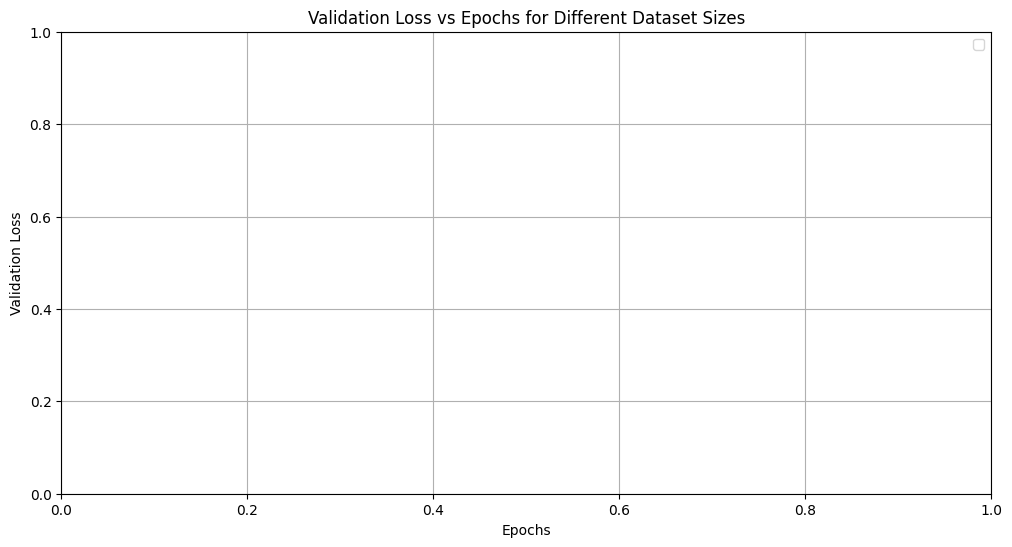

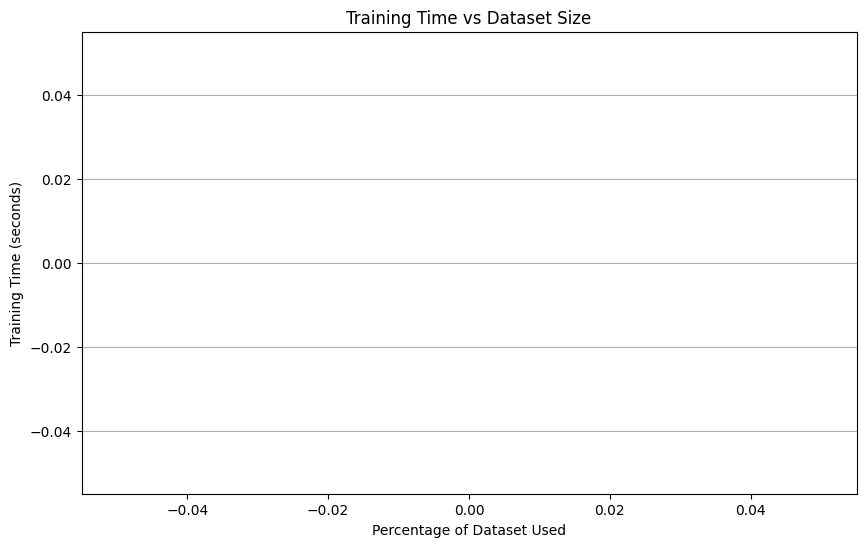

In [48]:
# Plot Validation Loss over epochs for all dataset fractions
plt.figure(figsize=(12, 6))
for res in results:
    plt.plot(res['val_losses'], label=f"{int(res['data_fraction']*100)}% data")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epochs for Different Dataset Sizes")
plt.legend()
plt.grid(True)
plt.show()

# Plot total training time vs data fraction
plt.figure(figsize=(10, 6))
fractions = [int(res['data_fraction']*100) for res in results]
times = [res['training_time_sec'] for res in results]
plt.bar(fractions, times, color='skyblue')
plt.xlabel("Percentage of Dataset Used")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time vs Dataset Size")
plt.grid(axis='y')
plt.show()

In [18]:

# Evaluate on test set
test_csv = "/mnt/d/Stanford_AIMI_CheXpert_Chest_X-rays/chexpertchestxrays-u20210408/valid.csv"
test_df = pd.read_csv(test_csv)

# Preprocessing steps (MATCH TRAIN)
train_tabular_cols = [
    "Age",
    "Age_scaled",
    "Sex_Male",
    "Sex_Unknown",
    "Frontal/Lateral_Lateral",
    "AP/PA_LL",
    "AP/PA_PA",
    "AP/PA_RL",
    "AP/PA_Unknown",
    "Age_group_40-60",
    "Age_group_60-80",
    "Age_group_80+",
    "View_Combo_Frontal_LL",
    "View_Combo_Frontal_PA",
    "View_Combo_Frontal_RL",
    "View_Combo_Lateral_Unknown",
]




# Age group + view combo (MATCH TRAIN)
test_df["Age_group"] = pd.cut(
    test_df["Age"],
    bins=[0, 40, 60, 80, 120],
    labels=["<40", "40-60", "60-80", "80+"]
)
test_df["View_Combo"] = (
    test_df["Frontal/Lateral"].astype(str) + "_" +
    test_df["AP/PA"].fillna("Unknown").astype(str)
)

# Missing values
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
test_df["Sex"] = test_df["Sex"].fillna("Unknown")
test_df["Frontal/Lateral"] = test_df["Frontal/Lateral"].fillna("Unknown")
test_df["AP/PA"] = test_df["AP/PA"].fillna("Unknown")
test_df[diagnosis_cols] = test_df[diagnosis_cols].fillna(0).astype(int)

# Age outliers
test_df = test_df[(test_df["Age"] >= 18) & (test_df["Age"] <= 100)]

# Scaling
scaler = StandardScaler()
test_df["Age_scaled"] = scaler.fit_transform(test_df[["Age"]])

# One‑hot encode (MATCH TRAIN)
test_df = pd.get_dummies(
    test_df,
    columns=["Sex", "Frontal/Lateral", "AP/PA", "Age_group", "View_Combo"],
    drop_first=True,
)

# Ensure all train tabular columns are present in test set
for col in train_tabular_cols:
    if col not in test_df.columns:
        test_df[col] = 0.0


# Convert Booleans into float32
bool_cols = test_df.select_dtypes(include=['bool']).columns.tolist()
col_to_convert = bool_cols + ['Age']
test_df[col_to_convert] = test_df[col_to_convert].astype('float32')

# Dimensionality Reduction
from sklearn.decomposition import PCA
meta_features = test_df.drop(columns=["Path"] + diagnosis_cols)
pca = PCA(n_components=5)
meta_pca = pca.fit_transform(meta_features)

print("Preprocessing complete. Sample of processed dataframe:")
print(test_df.head())




# load test dataset 
lmdb_test_path = f"/mnt/d/chexpert_lmdb_test"
test_dataset = XrayLMDBDatasetWithImages(lmdb_test_path, val_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False,
                        num_workers=3, pin_memory=True)
# Create LMDB datasets
ensure_lmdb(test_df, lmdb_test_path, image_root_local)
# Evaluate on test set


Preprocessing complete. Sample of processed dataframe:
                                                Path   Age  No Finding  \
0  CheXpert-v1.0/valid/patient64541/study1/view1_...  73.0           0   
1  CheXpert-v1.0/valid/patient64542/study1/view1_...  70.0           0   
2  CheXpert-v1.0/valid/patient64542/study1/view2_...  70.0           0   
3  CheXpert-v1.0/valid/patient64543/study1/view1_...  85.0           0   
4  CheXpert-v1.0/valid/patient64544/study1/view1_...  42.0           1   

   Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  Lung Lesion  Edema  \
0                           1             1             1            0      0   
1                           0             0             0            0      0   
2                           0             0             0            0      0   
3                           1             0             1            0      1   
4                           0             0             0            0      0   

   Consolidat

In [19]:
tabular_cols = [c for c in test_df.columns if c not in ['Path'] + diagnosis_cols]
print(df[tabular_cols].dtypes)

Age                           float32
Age_scaled                    float64
Sex_Male                      float32
Frontal/Lateral_Lateral       float32
AP/PA_PA                      float32
AP/PA_Unknown                 float32
Age_group_40-60               float32
Age_group_60-80               float32
Age_group_80+                 float32
View_Combo_Frontal_PA         float32
View_Combo_Lateral_Unknown    float32
Sex_Unknown                   float32
AP/PA_LL                      float32
AP/PA_RL                      float32
View_Combo_Frontal_LL         float32
View_Combo_Frontal_RL         float32
dtype: object



Loading model: best_model_100.pth


/home/jackb/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Model: best_model_100.pth | overall acc (label-wise): 0.8565 | macro AUC: 0.8997 | micro AUC: 0.9159
Top per-class AUCs (sorted):
  No Finding: 0.9585
  Lung Opacity: 0.9295
  Consolidation: 0.9273
  Pleural Other: 0.9227
  Support Devices: 0.9194
  Edema: 0.9160
  Pleural Effusion: 0.9158
  Pneumothorax: 0.9049
  Atelectasis: 0.9015
  Pneumonia: 0.8844


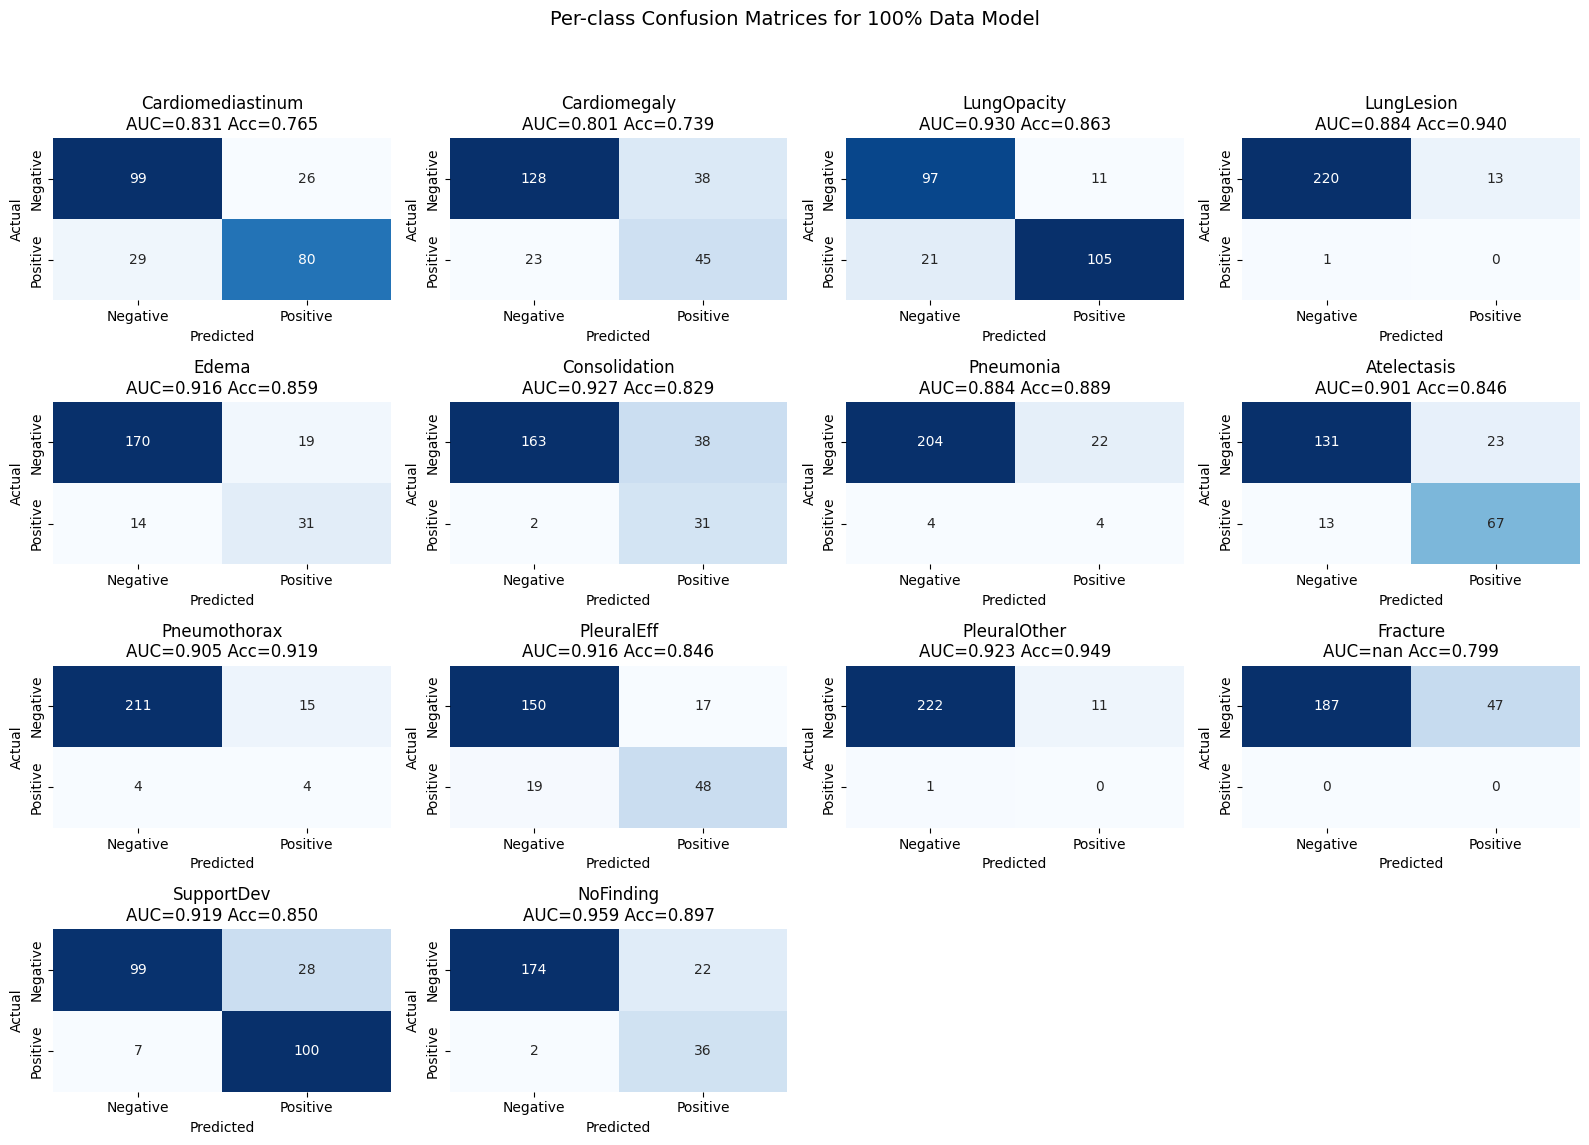


Loading model: best_model_25.pth


/home/jackb/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Model: best_model_25.pth | overall acc (label-wise): 0.8559 | macro AUC: 0.8810 | micro AUC: 0.9104
Top per-class AUCs (sorted):
  No Finding: 0.9530
  Pleural Effusion: 0.9241
  Consolidation: 0.9207
  Support Devices: 0.9140
  Lung Opacity: 0.9113
  Edema: 0.9016
  Atelectasis: 0.8916
  Pleural Other: 0.8627
  Lung Lesion: 0.8584
  Pneumonia: 0.8545


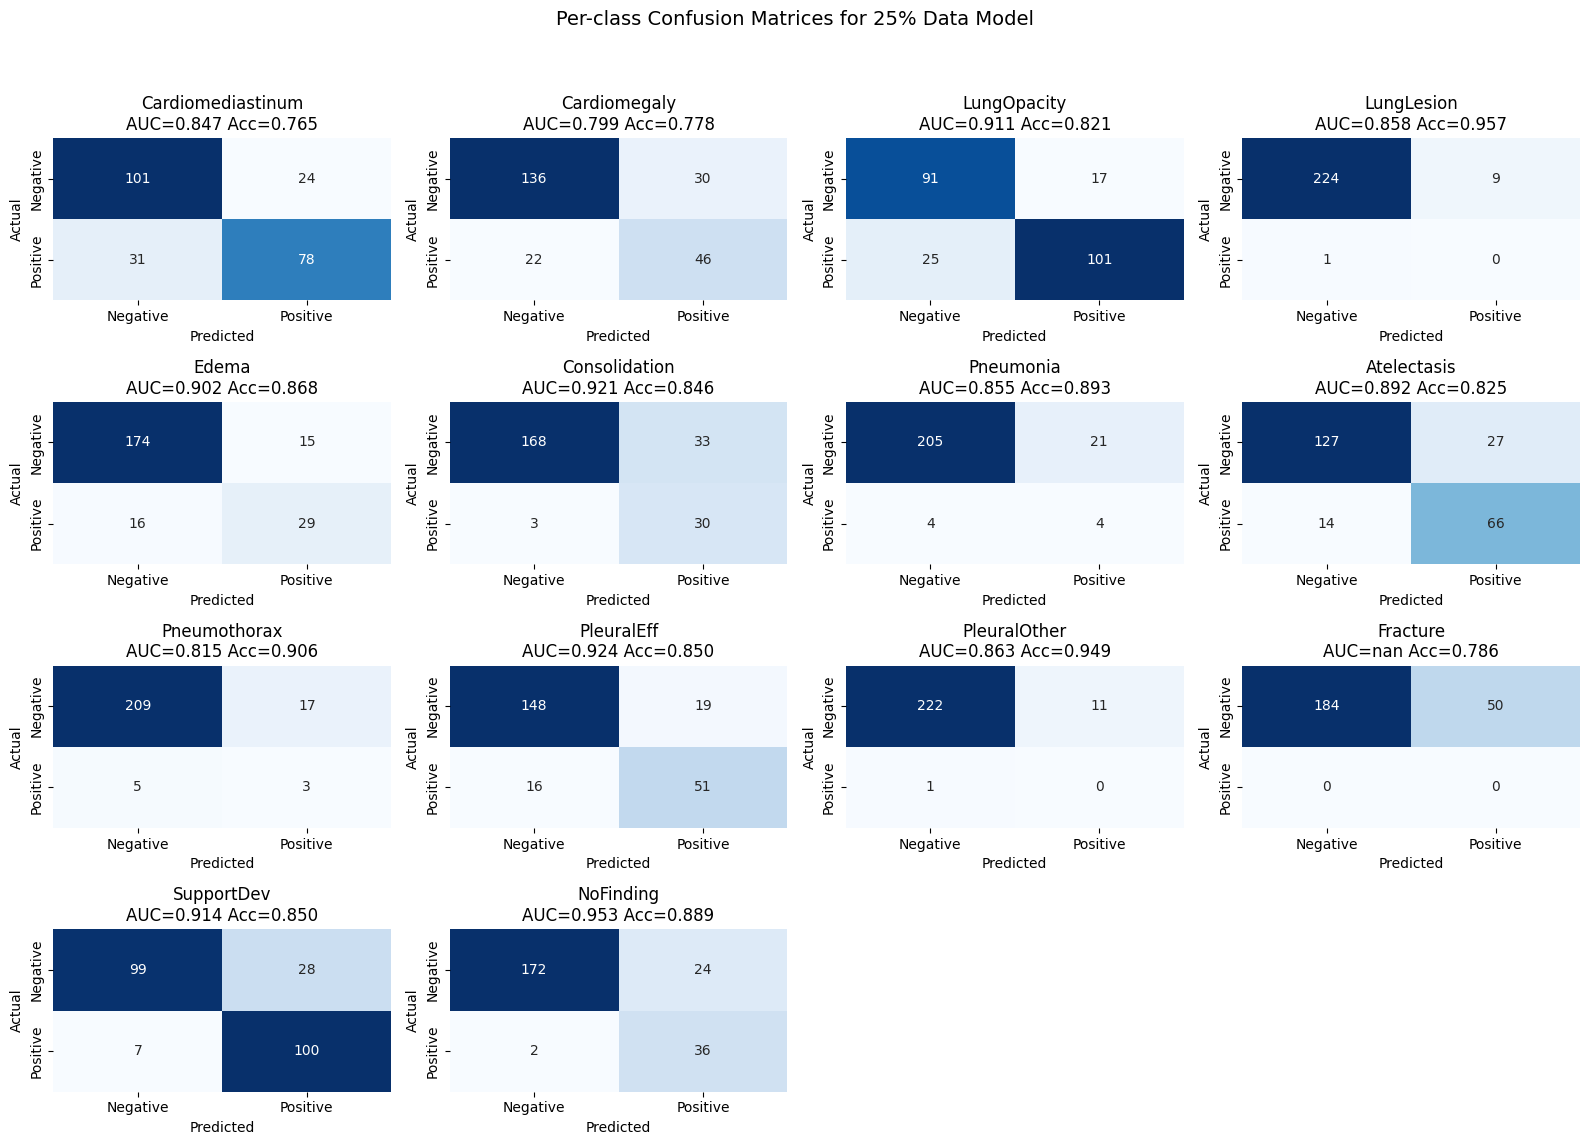


Loading model: best_model_50.pth


/home/jackb/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Model: best_model_50.pth | overall acc (label-wise): 0.8556 | macro AUC: 0.8865 | micro AUC: 0.9199
Top per-class AUCs (sorted):
  No Finding: 0.9586
  Support Devices: 0.9352
  Pleural Effusion: 0.9215
  Lung Opacity: 0.9200
  Edema: 0.9153
  Consolidation: 0.9145
  Atelectasis: 0.9021
  Pleural Other: 0.9013
  Pneumonia: 0.8650
  Enlarged Cardiomediastinum: 0.8420


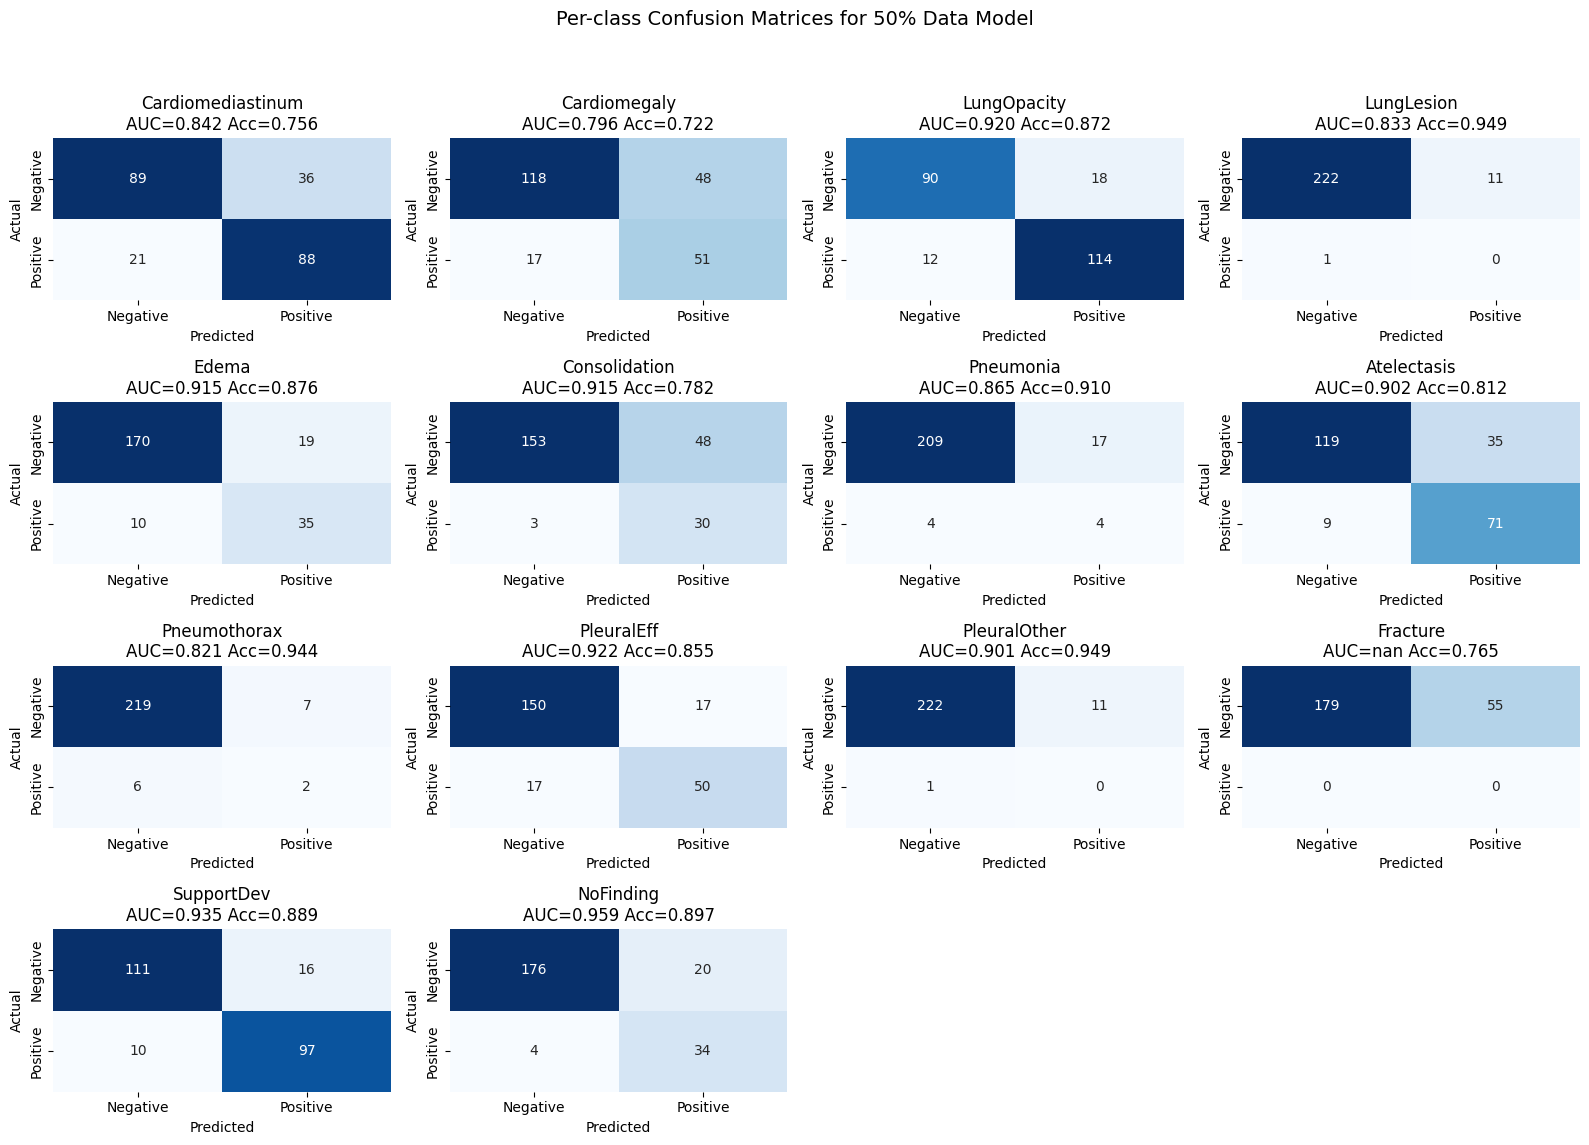


Loading model: best_model_75.pth


/home/jackb/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Model: best_model_75.pth | overall acc (label-wise): 0.8681 | macro AUC: 0.8678 | micro AUC: 0.9169
Top per-class AUCs (sorted):
  No Finding: 0.9507
  Support Devices: 0.9335
  Pleural Effusion: 0.9211
  Consolidation: 0.9141
  Lung Opacity: 0.9099
  Edema: 0.9015
  Atelectasis: 0.8928
  Enlarged Cardiomediastinum: 0.8502
  Pneumonia: 0.8496
  Pneumothorax: 0.8390


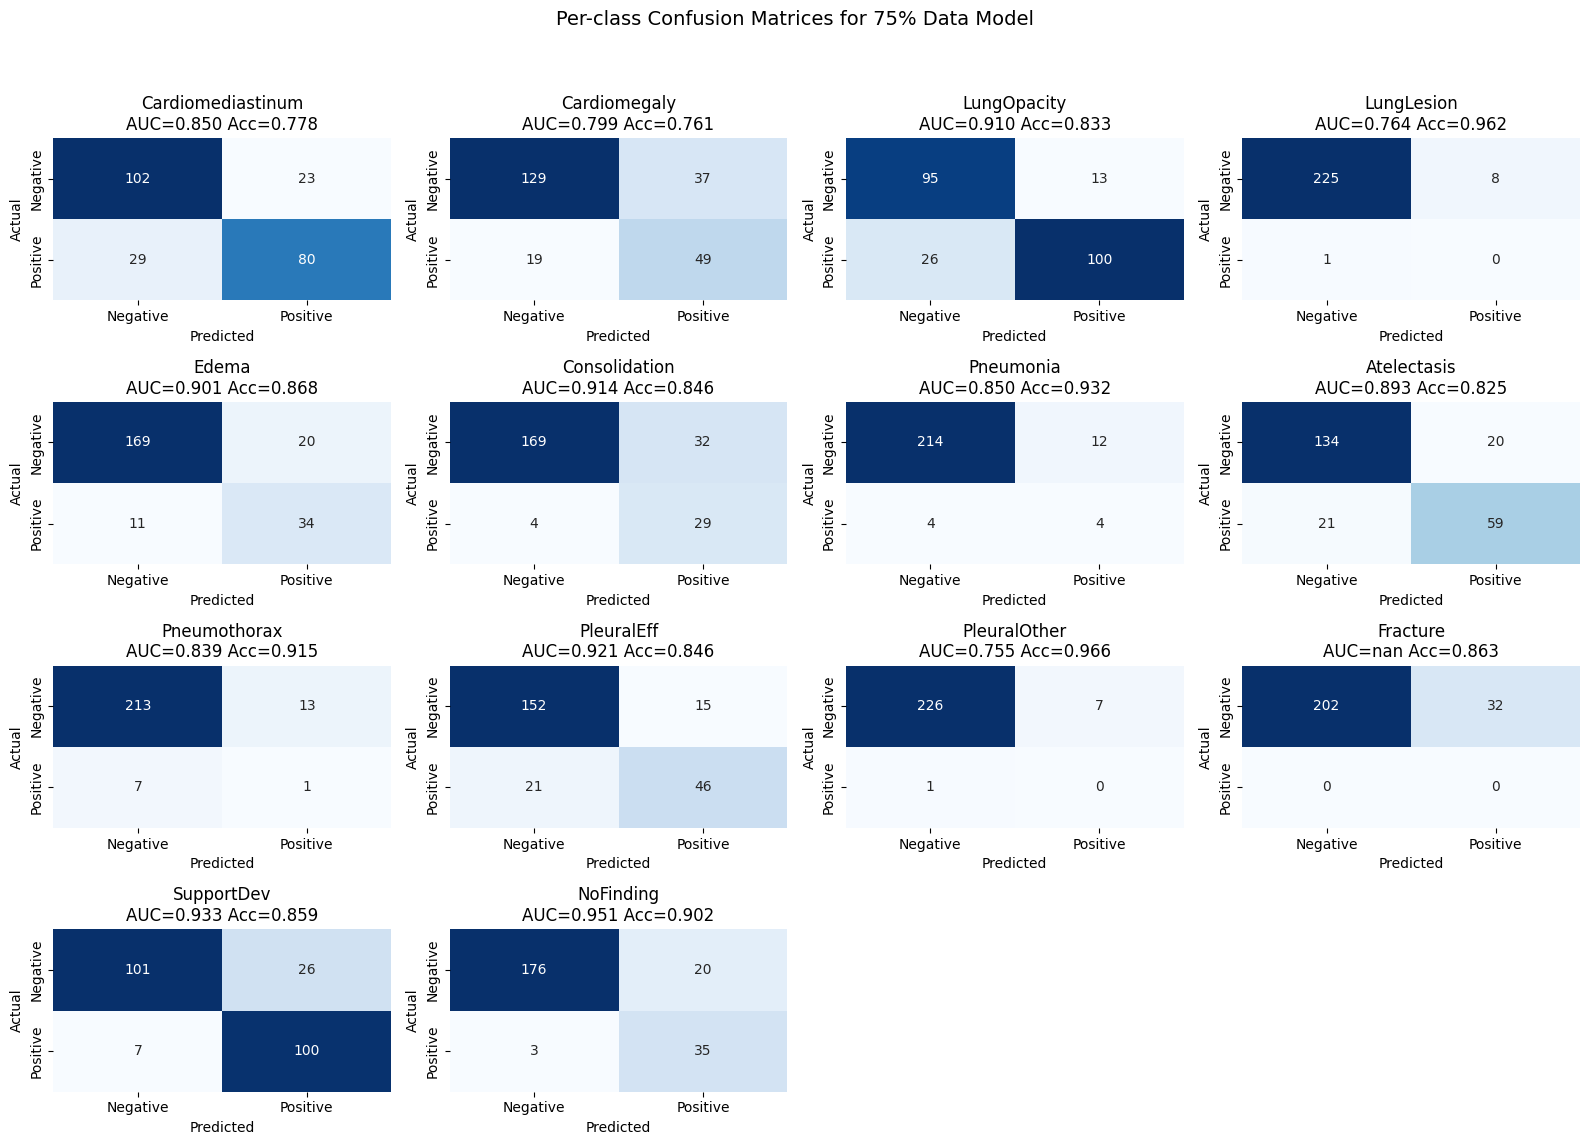

,model,class,auc,precision,recall,f1,support,accuracy,overall_acc,macro_auc,micro_auc
0,best_model_100.pth,Atelectasis,0.901461,0.744444,0.837500,0.788235,None,0.846154,0.856532,0.899734,0.915874
1,best_model_100.pth,Cardiomegaly,0.801028,0.542169,0.661765,0.596026,None,0.739316,0.856532,0.899734,0.915874
2,best_model_100.pth,Consolidation,0.927333,0.449275,0.939394,0.607843,None,0.829060,0.856532,0.899734,0.915874
3,best_model_100.pth,Edema,0.916049,0.620000,0.688889,0.652632,None,0.858974,0.856532,0.899734,0.915874
4,best_model_100.pth,Enlarged Cardiomediastinum,0.831266,0.754717,0.733945,0.744186,None,0.764957,0.856532,0.899734,0.915874
5,best_model_100.pth,Fracture,NaN,0.000000,0.000000,0.000000,None,0.799145,0.856532,0.899734,0.915874
6,best_model_100.pth,Lung Lesion,0.884120,0.000000,0.000000,0.000000,None,0.940171,0.856532,0.899734,0.915874
7,best_model_100.pth,Lung Opacity,0.929527,0.905172,0.833333,0.867769,None,0.863248,0.856532,0.899734,0.915874
8,best_model_100.pth,No Finding,0.958512,0.620690,0.947368,0.750000,None,0.897436,0.856532,0.899734,0.915874
9,best_model_100.pth,Pleural Effusion,0.915810,0.738462,0.716418,0.727273,None,0.846154,0.856532,0.899734,0.915874


Saved model_evaluation_summary.csv and plotted confusion matrices. Results dict is available as 'results'.


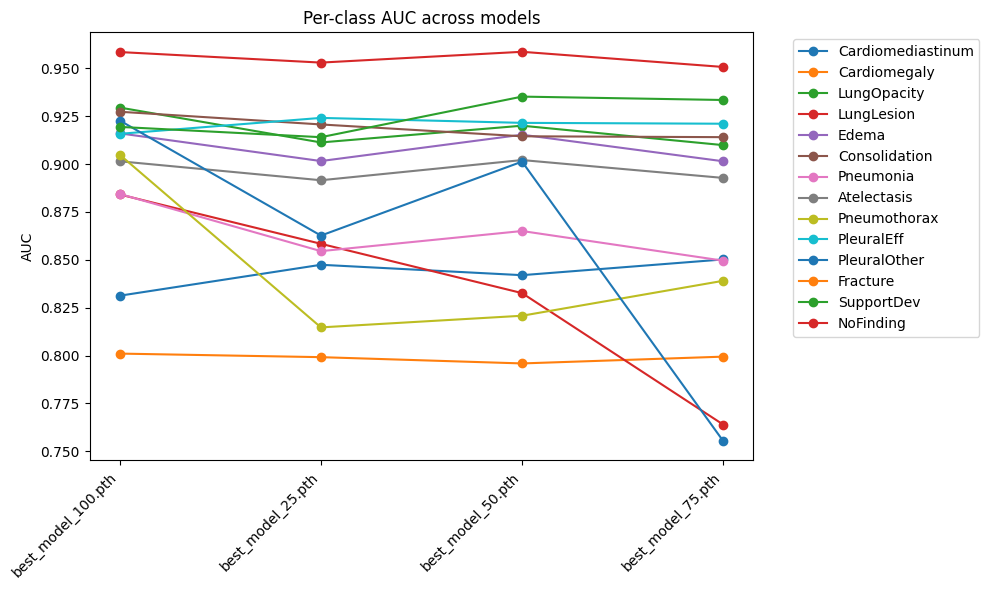

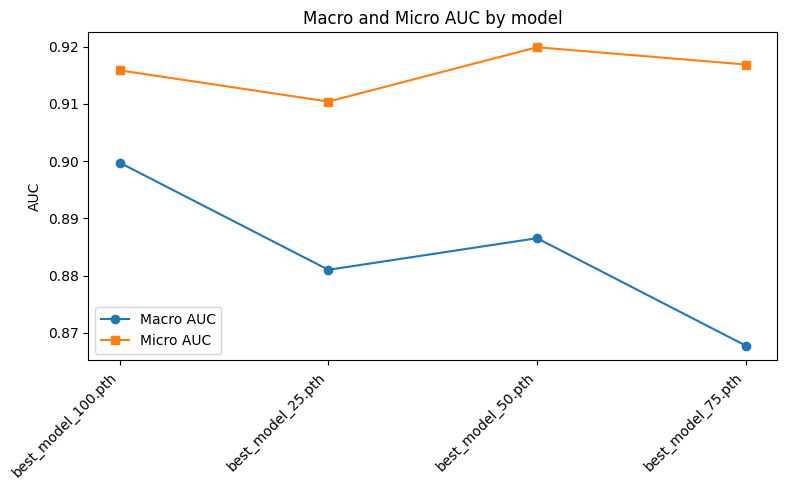

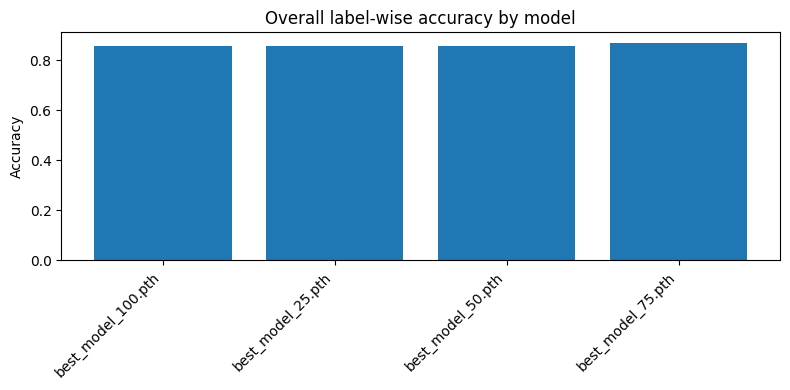

In [25]:
import glob
import pickle
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix
import math
import seaborn as sns
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Nice names mapping for display 
nice_names = {
    "Enlarged Cardiomediastinum": "Cardiomediastinum",
    "Cardiomegaly": "Cardiomegaly",
    "Lung Opacity": "LungOpacity",
    "Lung Lesion": "LungLesion",
    "Edema": "Edema",
    "Consolidation": "Consolidation",
    "Pneumonia": "Pneumonia",
    "Atelectasis": "Atelectasis",
    "Pneumothorax": "Pneumothorax",
    "Pleural Effusion": "PleuralEff",
    "Pleural Other": "PleuralOther",
    "Fracture": "Fracture",
    "Support Devices": "SupportDev",
    "No Finding": "NoFinding",
}

model_name_map = {
    "best_model_25.pth": "25% Data Model",
    "best_model_50.pth": "50% Data Model",
    "best_model_75.pth": "75% Data Model",
    "best_model_100.pth": "100% Data Model",
    # ...
}


# Collect model paths

model_paths = sorted(glob.glob("best_model_*.pth"))
if len(model_paths) == 0:
    print("No model files found matching best_model_*.pth in current directory.")
else:
    device = device if 'device' in globals() else torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )


    # Cache test images/tabular once
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for images, tabular, labels in test_loader:
            images, tabular = images.to(device), tabular.to(device)
            all_labels.append(labels.cpu().numpy())
            all_scores.append((images.cpu(), tabular.cpu()))

    y_true = np.vstack(all_labels)   # shape (N, C)
    n_samples, n_classes = y_true.shape

    results = {}


    # Evaluate each saved model looped 
    for mp in model_paths:
        nice_model_name = model_name_map.get(mp, mp) # Friendly name if available
        print(f"\nLoading model: {mp}")
        model = XrayMultimodalModel(
            num_tabular_features=len(tabular_cols),
            num_classes=len(diagnosis_cols)
        ).to(device)

        state = torch.load(mp, map_location=device)
        if isinstance(state, dict) and any(k.startswith("module.") for k in state.keys()):
            new_state = {}
            for k, v in state.items():
                nk = k.replace("module.", "") if k.startswith("module.") else k
                new_state[nk] = v
            state = new_state
        try:
            model.load_state_dict(state)
        except RuntimeError:
            if 'model_state_dict' in state:
                model.load_state_dict(state['model_state_dict'])
            else:
                raise
        model.eval()


        # Forward pass on cached test data
        scores_list = []
        with torch.no_grad():
            for (images_cpu, tabular_cpu) in all_scores:
                images_b = images_cpu.to(device)
                tabular_b = tabular_cpu.to(device)
                out = model(images_b, tabular_b)   # logits
                probs = torch.sigmoid(out).cpu().numpy()
                scores_list.append(probs)

        y_score = np.vstack(scores_list)        # shape (N, C)
        y_pred = (y_score > 0.5).astype(int)    # binary predictions

        # Per-class metrics
        per_class_auc = []
        per_class_confusion = []
        per_class_prf = []
        per_class_acc = []

        for i, cls in enumerate(diagnosis_cols):
            y_true_c = y_true[:, i]
            y_score_c = y_score[:, i]

            try:
                auc_val = roc_auc_score(y_true_c, y_score_c)
            except Exception:
                auc_val = float('nan')
            per_class_auc.append(auc_val)

            cm = confusion_matrix(y_true_c, y_pred[:, i], labels=[0, 1])
            per_class_confusion.append(cm)

            prf = precision_recall_fscore_support(
                y_true_c, y_pred[:, i],
                average='binary', zero_division=0
            )
            per_class_prf.append(prf)  # (precision, recall, f1, support)

            total = cm.sum()
            if total > 0:
                acc = (cm[0, 0] + cm[1, 1]) / total
            else:
                acc = float('nan')
            per_class_acc.append(acc)


        # Macro/micro AUC and overall accuracy
        # Macro AUC: mean of valid per-class AUCs
        valid_aucs = [a for a in per_class_auc if not math.isnan(a)]
        macro_auc = float(np.mean(valid_aucs)) if valid_aucs else float('nan')  # [web:76][web:92]

        # Micro AUC: use sklearn directly on all labels
        try:
            micro_auc = roc_auc_score(y_true, y_score, average='micro')  # [web:76]
        except Exception:
            micro_auc = float('nan')

        overall_acc = (y_pred == y_true).sum() / y_true.size

        precisions = [p for p, r, f, s in per_class_prf]
        recalls    = [r for p, r, f, s in per_class_prf]
        f1s        = [f for p, r, f, s in per_class_prf]
        supports   = [s for p, r, f, s in per_class_prf]

        results[mp] = {
            "per_class_auc": dict(zip(diagnosis_cols, per_class_auc)),
            "macro_auc": macro_auc,
            "micro_auc": micro_auc,
            "precision": dict(zip(diagnosis_cols, precisions)),
            "recall": dict(zip(diagnosis_cols, recalls)),
            "f1": dict(zip(diagnosis_cols, f1s)),
            "support": dict(zip(diagnosis_cols, supports)),
            "per_class_accuracy": dict(zip(diagnosis_cols, per_class_acc)),
            "overall_accuracy": overall_acc,
            "per_class_confusion": dict(zip(diagnosis_cols, per_class_confusion)),
        }

        print(
            f"Model: {mp} | overall acc (label-wise): {overall_acc:.4f} "
            f"| macro AUC: {macro_auc:.4f} | micro AUC: {micro_auc:.4f}"
        )
        print("Top per-class AUCs (sorted):")
        for cls, a in sorted(
            results[mp]["per_class_auc"].items(),
            key=lambda x: (math.isnan(x[1]), -x[1] if not math.isnan(x[1]) else 0)
        )[:10]:
            print(f"  {cls}: {a:.4f}")

        # Per-class confusion matrices (better labels)
        n = n_classes
        cols = 4
        rows = (n + cols - 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
        axs = axs.flatten()

        for idx, cls in enumerate(diagnosis_cols):
            cm = results[mp]["per_class_confusion"][cls]
            sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cbar=False,
                ax=axs[idx],
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"],
                cmap="Blues"
            )
            auc_val = results[mp]['per_class_auc'][cls]
            acc_val = results[mp]['per_class_accuracy'][cls]
            short = nice_names.get(cls, cls)
            axs[idx].set_title(f"{short}\nAUC={auc_val:.3f} Acc={acc_val:.3f}")
            axs[idx].set_xlabel("Predicted")
            axs[idx].set_ylabel("Actual")

        for i in range(n, len(axs)):
            axs[i].axis('off')

        plt.suptitle(f"Per-class Confusion Matrices for {nice_model_name}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # Build summary DataFrame
    summary_rows = []
    for mp, r in results.items():
        for cls in diagnosis_cols:
            summary_rows.append({
                "model": mp,
                "class": cls,
                "auc": r["per_class_auc"][cls],
                "precision": r["precision"][cls],
                "recall": r["recall"][cls],
                "f1": r["f1"][cls],
                "support": r["support"][cls],
                "accuracy": r["per_class_accuracy"][cls],
                "overall_acc": r["overall_accuracy"],
                "macro_auc": r["macro_auc"],
                "micro_auc": r["micro_auc"],
            })

    summary_df = pd.DataFrame(summary_rows)
    display(summary_df.sort_values(["model", "class"]).reset_index(drop=True))
    summary_df.to_csv("model_evaluation_summary.csv", index=False)
    print("Saved model_evaluation_summary.csv and plotted confusion matrices. Results dict is available as 'results'.")

    # Line chart: per-class AUC across models
    plt.figure(figsize=(10, 6))
    for cls in diagnosis_cols:
        cls_df = summary_df[summary_df["class"] == cls].sort_values("model")
        short = nice_names.get(cls, cls)
        plt.plot(cls_df["model"], cls_df["auc"], marker="o", label=short)

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("AUC")
    plt.title("Per-class AUC across models")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Line chart: macro and micro AUC per model
    macro_micro = (
        summary_df[["model", "macro_auc", "micro_auc"]]
        .drop_duplicates()
        .sort_values("model")
    )

    plt.figure(figsize=(8, 5))
    plt.plot(macro_micro["model"], macro_micro["macro_auc"], marker="o", label="Macro AUC")
    plt.plot(macro_micro["model"], macro_micro["micro_auc"], marker="s", label="Micro AUC")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("AUC")
    plt.title("Macro and Micro AUC by model")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Line chart: overall accuracy per model
    overall = (
        summary_df[["model", "overall_acc"]]
        .drop_duplicates()
        .sort_values("model")
    )

    plt.figure(figsize=(8, 4))
    plt.bar(overall["model"], overall["overall_acc"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Accuracy")
    plt.title("Overall label-wise accuracy by model")
    plt.tight_layout()
    plt.show()


In [63]:
best_macro_model, best_macro_metrics = max(
    results.items(),
    key=lambda kv: kv[1]["macro_auc"]
)
print("Best model by macro AUC:", best_macro_model)
print("Macro AUC:", best_macro_metrics["macro_auc"])
print("Micro AUC:", best_macro_metrics["micro_auc"])
print("Overall accuracy:", best_macro_metrics["overall_accuracy"])


Best model by macro AUC: best_model_100.pth
Macro AUC: nan
Micro AUC: 0.9158744510100855
Overall accuracy: 0.8565323565323565


In [64]:
best_micro_model, best_micro_metrics = max(
    results.items(),
    key=lambda kv: kv[1]["micro_auc"]
)
print("Best model by micro AUC:", best_micro_model)


Best model by micro AUC: best_model_50.pth


In [65]:
best_acc_model, best_acc_metrics = max(
    results.items(),
    key=lambda kv: kv[1]["overall_accuracy"]
)
print("Best model by overall accuracy:", best_acc_model)


Best model by overall accuracy: best_model_75.pth
